# Social Network Simulation

## Notes:
Improving the social dynamics model on Adaptive Networks. Proposing changes to the model to make the dynamics more realistic in some way. Implement the improvements in a simulation, and analyzing the expected (theoretical) and actual (experimental) effects of changes on the model.

## Simulation code

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern'],'size': 18})
rc('text', usetex=True)
import scipy.stats as sts
import trueskill as ts
import networkx as nx
import random as rn
import numpy as np
import itertools
import names

In [7]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
            
            topics (list of strings) Each node has a value (0 or 1) for each 
            topic of discussion that are randomly selected for discussion. 
              Default: ['politics', 'religiousness', 'mindset']
        '''
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.topics = ['politics', 'religiousness', 'mindset']
        self.conversations = [] # Register conversations
        self.names = [] # Name associated with each node

    def initialize(self, graph_type, TS=False):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        # Initialize the desired type of graph based on input
        self.graph = graph_type
        self.env = ts.TrueSkill()
        # Loop thru the edges and assign 0.5 weight to each of them
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        # Loop thru the nodes of the graph
        for node in self.graph.nodes:
            # Make sure the name is unique in the network
            while True:
                temp = names.get_first_name()
                if temp not in self.names:
                    # Assing a name to the node
                    self.graph.nodes[node]['name'] = temp
                    self.names.append(temp); break
            # Assign an initial opinin for the node on each topic
            for topic in self.topics:
                self.graph.nodes[node][topic] = rn.randint(0, 1)
            # Add the persuasiveness attribute using TrueSkill
            if TS:
                self.graph.nodes[node]['rating'] = self.env.Rating(mu=50)#mu=rn.choice(range(5, 10)), sigma=1)
        # Setup the layout of the graph
        self.layout = nx.spring_layout(self.graph)
        # Initialize the step counter
        self.step = 0
    
    def avg_deg_neighbor(self):
        '''
        Returns the average degree of neighbor to test for the 
        friendship paradox by comparing against network's average degree 
        '''
        node, deg = 0, 0
        # Loops thru all the edges of the graph
        for edge in self.graph.edges():
            # Loops thru all neighbors of the edge
            for neighbor in edge:
                deg += len(self.graph.edges(neighbor))
                node += 1
        return round(deg / node, 2)
    
    def dunbar(self):
        '''
        Returns the distribution of the of nodes' sum of edge weights
        both unnormalized (the sum of the node's edge_weights) and 
        normalized (the sum divided by the number of edges)
        '''
        output_1, output_2, nodes = [], [], list(self.graph.nodes)
        # Loop thru the nodes of the graph
        for i in nodes:
            # Initialize a counter and list the edges of node i
            dunbar, edges = 0, list(self.graph.edges(i))
            # Loop thru the edges of node i
            for j in edges:
                # Add the weight of the edges to the counter
                dunbar += self.graph.edges[j]['weight']
            # Normalize the counter by dividing on the number of edges
            output_1.append(dunbar/(len(edges)+1))
            # Saves the sum of the counter without normalizing
            output_2.append(dunbar)
            
        # Graphing the results as histograms
        plt.figure(figsize=(15, 5))
        plt.subplot(1,2,1)
        plt.hist(output_1, bins = 'auto', density=False)
        plt.title("Distribution of nodes' edge weights\n (normalized)")
        plt.xlabel('Sum of edge weights'); plt.ylabel('Frequency')
        plt.subplot(1,2,2)
        plt.hist(output_2, bins = 'auto', density=False)
        plt.title("Distribution of nodes' edge weights\n (unnormalized)")
        plt.xlabel('Sum of edge weights'); plt.ylabel('Frequency')
        plt.show()
        
    def test_small_world(self):
        '''
        Returns the small-world coefficient (sigma, omega) of the given graph.
        sigma = C/Cr / L/Lr
        omega = Lr/L - C/Cl
        C = the average clustering coefficient of G
        L = the average shortest path length of G
        Cr = the average clustering coefficient of an equivalent random graph
        Lr = the average shortest path length of an equivalent random graph
        Cl = the average clustering coefficient of an equivalent lattice graph
        
        A graph is commonly classified as small-world if sigma > 1
        The small-world coefficient (omega) ranges between -1 and 1.
        [Source: Networkx Library https://networkx.github.io/]
        '''
        if nx.is_connected(self.graph):
            sigma = round(nx.sigma(self.graph), 2)
            omega = round(nx.omega(self.graph), 2)
            print('Small-world:', sigma>1 ,' sigma = {} > 1'.format(sigma),
                  '\nSmall-world:', -1<omega<1,' -1 < omega = {} < 1'.format(omega))
        else: print('The graph is not connected')

    def observe_modified(self):
        '''
        Draw the state of the network.
        Color coding: Blue 0 -----> 1 Red
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.figure(figsize=(20, 7))
        # Create a graph for each topic
        for k in range(len(self.topics)):
            plt.subplot(1, 3, k+1)
            nx.draw(
            self.graph, pos=self.layout, with_labels=True, edgecolors='black',
            node_color=[self.graph.nodes[i][self.topics[k]] for i in self.graph.nodes],
            cmap='seismic', alpha=0.7, vmin=0, vmax=1, node_size=450,
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
            plt.title('Graph of '+self.topics[k]+' - step: ' + str(self.step), fontsize=16)
        plt.show()
    
    def update_modified(self):
        '''
        Updates the values of opinions and the weights of the edges.
        Each conversation revolves on one of three topics.
        '''
        # Part I: creating a new edge with probability of 1%
        if rn.uniform(0,1) < 0.01:
            # Create a new edge between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = rn.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            
            # MODIFICATION
            # The weight of the new edge is proportional to the degree of separation
            if nx.has_path(self.graph, new_edge[0], new_edge[1]):
                new_weight = 1 / (nx.shortest_path_length(self.graph, new_edge[0], new_edge[1]))
            else: 
                # Connected_Component_Subgraphs: Sort all subgraphs based on length
                CCS = sorted(nx.connected_components(self.graph), key=len, reverse=True)
                # Identify the giant component of the graph
                GC = self.graph.subgraph(CCS[0])
                # Attribute the appropriate wieght to the new edge
                new_weight = 1 / (nx.diameter(GC) + 1)
                
            # Assign the weight to the newly-formed connection
            self.graph.add_edge(new_edge[0], new_edge[1], weight=new_weight)
            
        # Part II: update the edge weight and opinions of a random couple
        else:
            # Select a random edge and update node opinions and edge weight
            edge = rn.choice(list(self.graph.edges))
            # Register the intial weight of the edge
            weight = self.graph.edges[edge]['weight']
            
            # MODIFICATION
            # Select a topic randomly
            topic = rn.choice(self.topics)
            # Register the opinion of the two nodes on the topic
            opinions = [self.graph.nodes[n][topic] for n in edge]
            
            # Updating the nodes' opinions
            for i in [0, 1]:
                self.graph.nodes[edge[i]][topic] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
                
            # Updating the edge weight
            self.graph.edges[edge]['weight'] = (
                weight + self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
                
        self.step += 1
        
    def update_trueskill(self):
        '''
        Building on the update_modified function, this function uses 
        TrueSkill model to treat each conversation as a game.
        '''
        if rn.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = rn.sample(nodes, 2)
                if new_edge not in self.graph.edges: break
                    
            # MODIFICATION
            # The weight of the new edge is proportional to the degree of separation
            if nx.has_path(self.graph, new_edge[0], new_edge[1]):
                new_weight = 1 / (nx.shortest_path_length(self.graph, new_edge[0], new_edge[1]))
            else: 
                # Connected_Component_Subgraphs: Sort all subgraphs based on length
                CCS = sorted(nx.connected_components(self.graph), key=len, reverse=True)
                # Identify the giant component of the graph
                GC = self.graph.subgraph(CCS[0])
                # Attribute the appropriate wieght to the new edge
                new_weight = 1 / (nx.diameter(GC) + 1)
                
            # Assign the weight to the newly-formed connection
            self.graph.add_edge(new_edge[0], new_edge[1], weight=new_weight)
            #self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = rn.choice(list(self.graph.edges))
            # Register the intial weight of the edge
            weight = self.graph.edges[edge]['weight']
            
            # MODIFICATION
            # Select a topic randomly
            topic = rn.choice(self.topics)
            # Register the opinion of the two persons on the topic
            opinions = [self.graph.nodes[n][topic] for n in edge]
            
            # Select a persuasiveness performance based on skill of each person
            perf_1 = sts.norm(self.graph.nodes[edge[0]]['rating'].mu, 
                              self.graph.nodes[edge[0]]['rating'].sigma).rvs()
            perf_2 = sts.norm(self.graph.nodes[edge[1]]['rating'].mu, 
                              self.graph.nodes[edge[1]]['rating'].sigma).rvs()
            """
            print('Opinion on a topic:\nPerson i: ', self.graph.nodes[edge[0]][topic], 
                  '\nPerson j: ', self.graph.nodes[edge[1]][topic])
            
            print('Persuasiveness skill:\nPerson i: ', self.graph.nodes[edge[0]]['rating'], 
                  '\nPerson j: ', self.graph.nodes[edge[1]]['rating'])
            print('Sampled persuasiveness performance:\nPerson i: ', perf_1, '\nPerson j: ', perf_2)
            """
            # Normalize the persuasiveness performance for each person
            p = perf_1 / (perf_1 + perf_2)
            #print('Normalized performance:\nPerson i: ', p, '\nPerson j: ', 1-p)
            
            # Update the opinion of each person on the topic based on their persuasiveness
            self.graph.nodes[edge[0]][topic] = (
                opinions[0] + (1-p) * self.alpha * weight * (opinions[1] - opinions[0]))
            self.graph.nodes[edge[1]][topic] = (
                opinions[1] + (p) * self.alpha * weight * (opinions[0] - opinions[1]))
            # Register the conversation and which person convinced more
            self.conversations.append([self.graph.nodes[edge[0 if p>.5 else 1]]['name'], 
                                       self.graph.nodes[edge[0 if p<.5 else 1]]['name'], 1, 0 ])
            # Update the persuasiveness skill for each person
            self.graph.nodes[edge[0 if p>.5 else 1]]['rating'], \
            self.graph.nodes[edge[0 if p<.5 else 1]]['rating'] = \
            self.env.rate_1vs1(self.graph.nodes[edge[0 if p>.5 else 1]]['rating'], 
                          self.graph.nodes[edge[0 if p<.5 else 1]]['rating'])
            """
            print('Opinion on a topic:\nPerson i: ', self.graph.nodes[edge[0]][topic], 
                  '\nPerson j: ', self.graph.nodes[edge[1]][topic])
            print('Updated persuasiveness skill:\nPerson i: ', self.graph.nodes[edge[0]]['rating'], 
                  '\nPerson j: ', self.graph.nodes[edge[1]]['rating'])
            """
            # Updating the edge weight
            self.graph.edges[edge]['weight'] = (
                weight + self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

In [17]:
sim_tts = SocialDynamicsSimulation()
sim_tts.initialize(nx.watts_strogatz_graph(50, 5, 0.5), TS=True)
sim_tts.update_trueskill()

Opinion on a topic:
Person i:  0 
Person j:  1
Persuasiveness skill:
Person i:  trueskill.Rating(mu=7.000, sigma=1.000) 
Person j:  trueskill.Rating(mu=6.000, sigma=1.000)
Sampled persuasiveness performance:
Person i:  6.6106086087288265 
Person j:  5.727960435822412
Normalized performance:
Person i:  0.5357678499718813 
Person j:  0.4642321500281187
Opinion on a topic:
Person i:  0.00696348225042178 
Person j:  0.9919634822504217
Updated persuasiveness skill:
Person i:  trueskill.Rating(mu=7.128, sigma=0.995) 
Person j:  trueskill.Rating(mu=5.872, sigma=0.995)


## Local analysis

In [490]:
def vectorfield(alpha, beta, gamma):
    '''
    Sub-function for plotting the vector fields. 
    Returns grids for plotting the vectors.
    '''
    opinion = weight = np.linspace(0, 1, 11)
    ow_grid = np.meshgrid(opinion, weight)
    delta_o_grid = -2 * alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1 - ow_grid[1]) * (1 - gamma * ow_grid[0])
    return ow_grid, delta_o_grid, delta_w_grid

def calculate_traces(alpha, beta, gamma, ow):
    '''
    Sub-function for plotting the vector fields. Returns
    grid for how opinions and weights change for plotting
    the trace lines that show convergence.
    '''
    for i in range(100):
        delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
        delta_w = (beta * ow[-1][2] * (1-ow[-1][2]) *
                  (1 - gamma * abs(ow[-1][1] - ow[-1][0])))
        new_weight = ow[-1][2] + delta_w
        if new_weight < 0.05: new_weight = 0
        ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
    return ow

In [491]:
def plot_vectorfield(param, param_range):
    '''
    Iterates over values of alpha, beta and gamma while keeping
    the other parameters constant at their default values and plots 
    their respective vector fields in a grid.
    '''
    alpha, beta, gamma = .03, .3, 4
    grid = [[0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
            [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
            [0.95, 0.35], [0.3, 0.25],  [0.3, 0.15],  [0.15, 0.06], [0.05, 0.06]]

    plt.figure(figsize=(15, 10))
    cmap = plt.cm.seismic
    for var in param_range:
        if param == 'alpha': alpha = var
        elif param == 'beta': beta = var
        else: gamma = var
        plt.subplot(2, 3, param_range.index(var)+1)
        
        for opinion, weight in grid:   
            ow = [[opinion, 0.0, weight]]
            ow = calculate_traces(alpha, beta, gamma, ow)
            
            plt.plot([row[0] - row[1] for row in ow], [row[2] for row in ow],
                     color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)), alpha=0.9)
        
        ow_grid, delta_o_grid, delta_w_grid = vectorfield(alpha, beta, gamma)
        
        plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid, width=.004)
        plt.title('{}: %.2f'.format(param) %var)
        plt.xlabel('opinion difference')
        plt.ylabel('weight')
        plt.axhline(0, color='black', linewidth=.5, linestyle='-.')
    plt.show()

In [492]:
def plot_new_relationships(alpha=.03, beta=.3, gamma=4):
    
    grid = [[0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
            [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
            [0.95, 0.35], [0.3, 0.25],  [0.3, 0.15],  [0.15, 0.06], [0.05, 0.06]]

    plt.figure(figsize=(10, 10))
    cmap = plt.cm.viridis
    
    for opinion, weight in grid:   
        ow = [[opinion, 0.0, weight]]
        ow = calculate_traces(alpha, beta, gamma, ow)  
        plt.plot([row[0] - row[1] for row in ow], [row[2] for row in ow], 
                 color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)), alpha=0.9)
        
    ow_grid, delta_o_grid, delta_w_grid = vectorfield(alpha, beta, gamma)
    plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid, width=.0025)
    plt.title('New relationships formation\nalpha=0.03, beta=0.3, gamma=4', fontsize=20)
    plt.xlabel('opinion difference')
    plt.ylabel('weight')
    for _ in range(2, 8):
        plt.axhline(1/_, color='red', linewidth=1, linestyle='-')
        plt.text(1.1, 1/_, '1/{}'.format(_))
    plt.show()

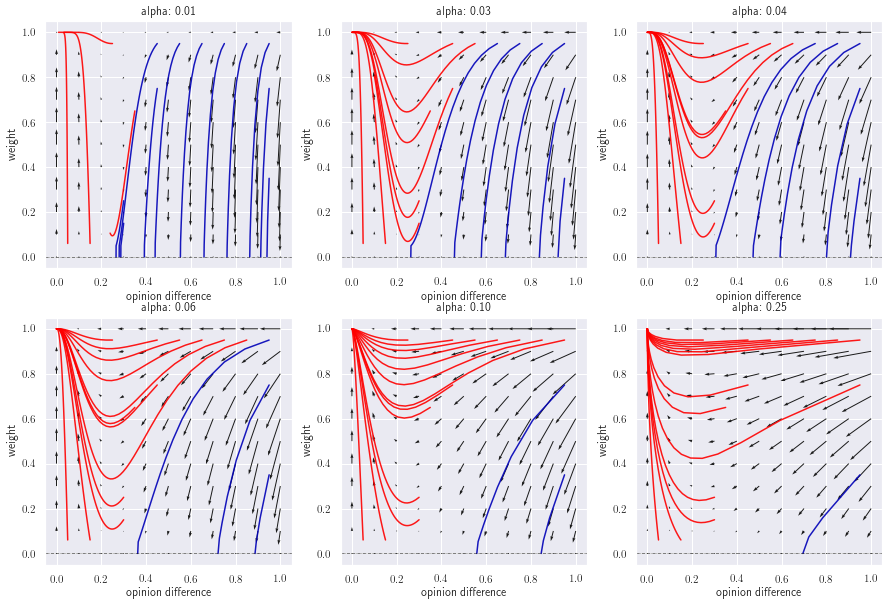

In [493]:
import seaborn as sns
sns.set()
alphas = [0.01, 0.03, 0.04, 0.06, 0.1, 0.25]
plot_vectorfield('alpha', alphas)

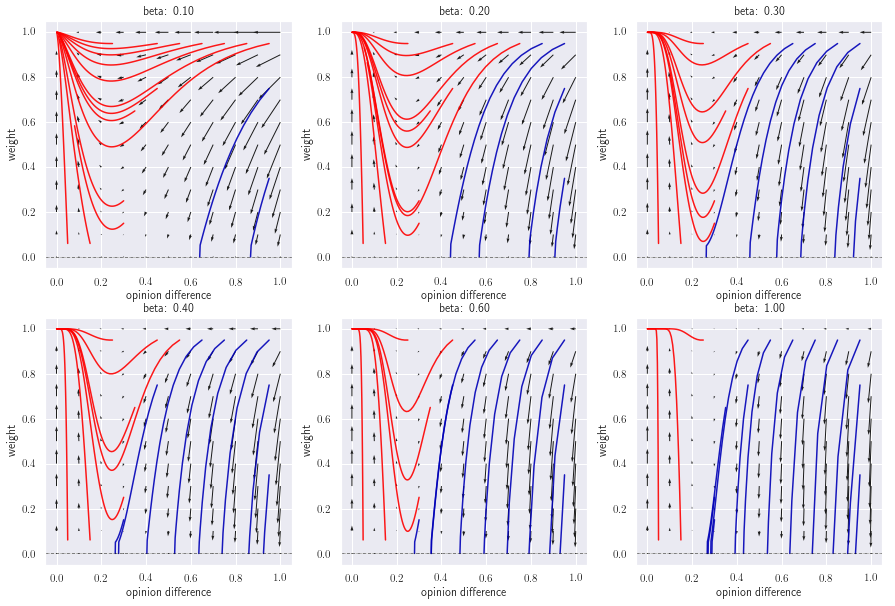

In [494]:
betas = [0.1, 0.2, 0.3, 0.4, 0.6, 1]
plot_vectorfield('beta', betas)

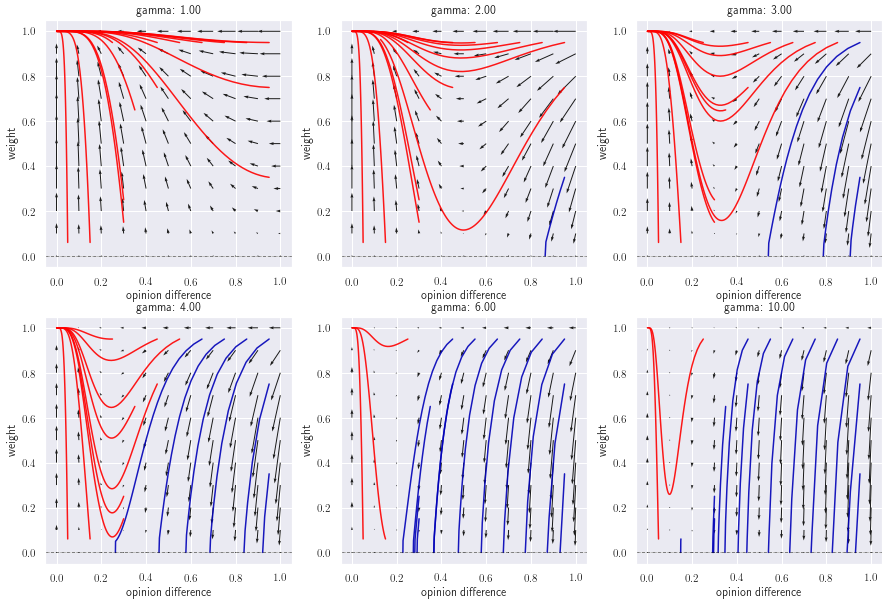

In [495]:
gammas = [1, 2, 3, 4, 6, 10]
plot_vectorfield('gamma', gammas)

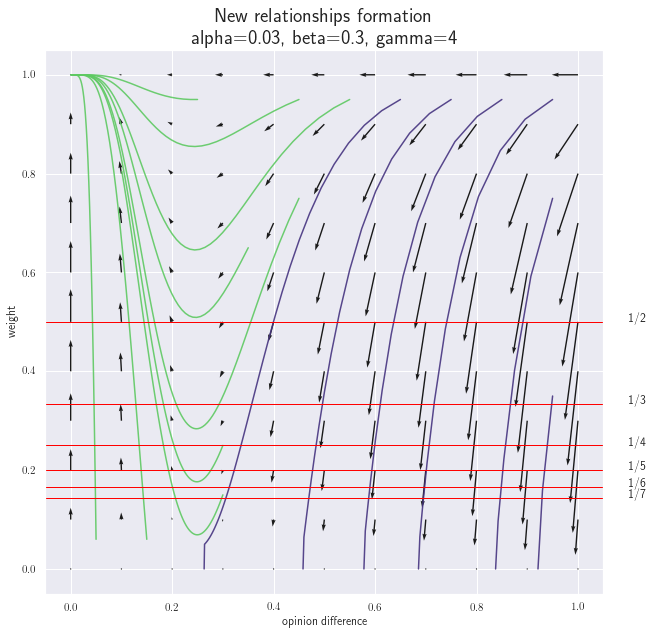

In [496]:
# Dynamics of new relationships
plot_new_relationships()

## TrueSkill model: Persuasiveness

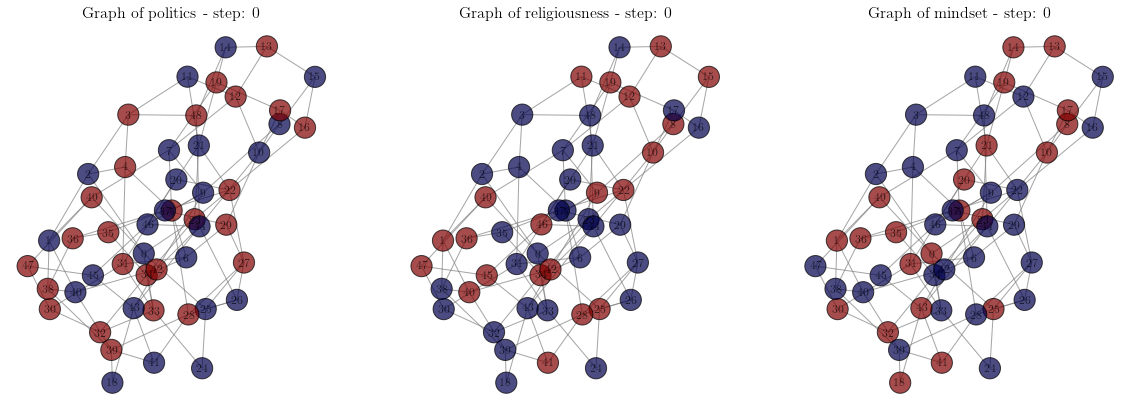

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 100
Average degree:   4.0000 
Average degree of neighbors in:  4.24


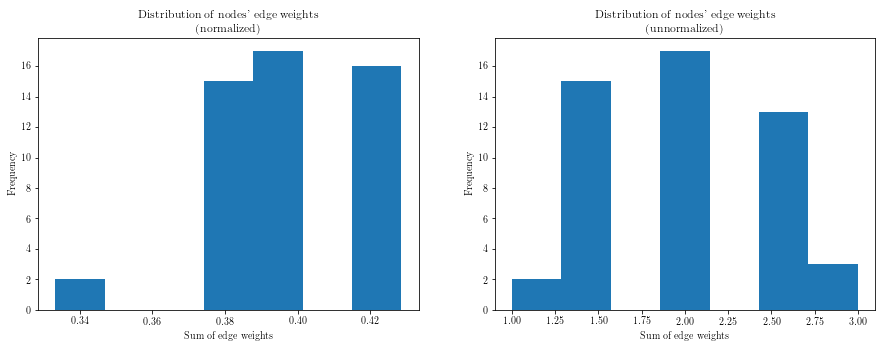

In [8]:
sim_ts = SocialDynamicsSimulation()
sim_ts.initialize(nx.watts_strogatz_graph(50, 5, 0.5), TS=True)
sim_ts.observe_modified()
print(nx.info(sim_ts.graph), '\nAverage degree of neighbors in: ', sim_ts.avg_deg_neighbor())
sim_ts.dunbar()

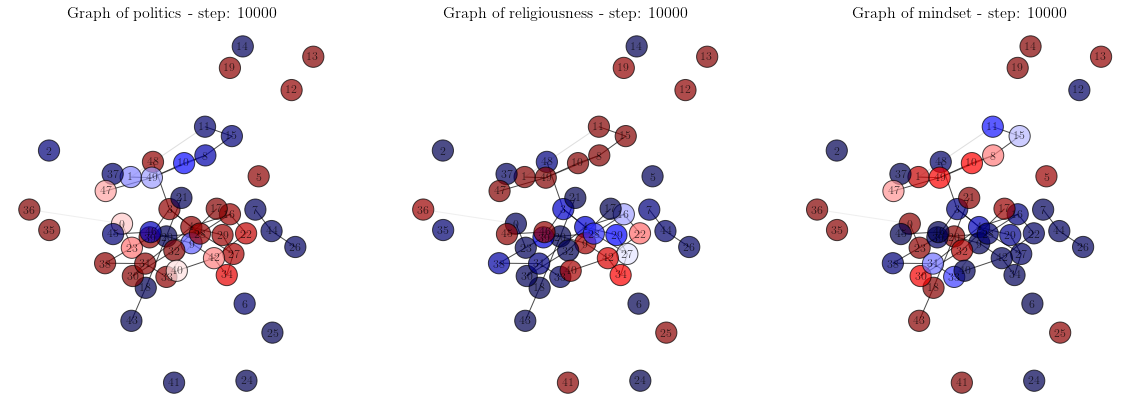

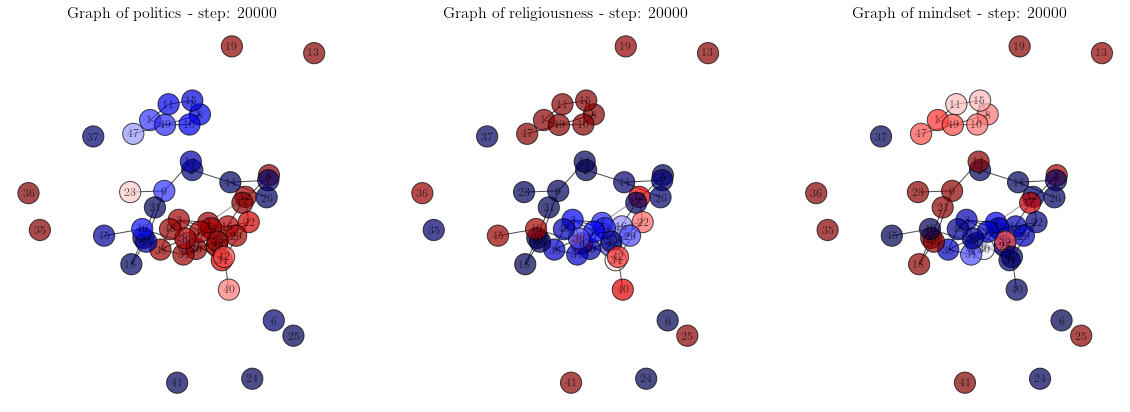

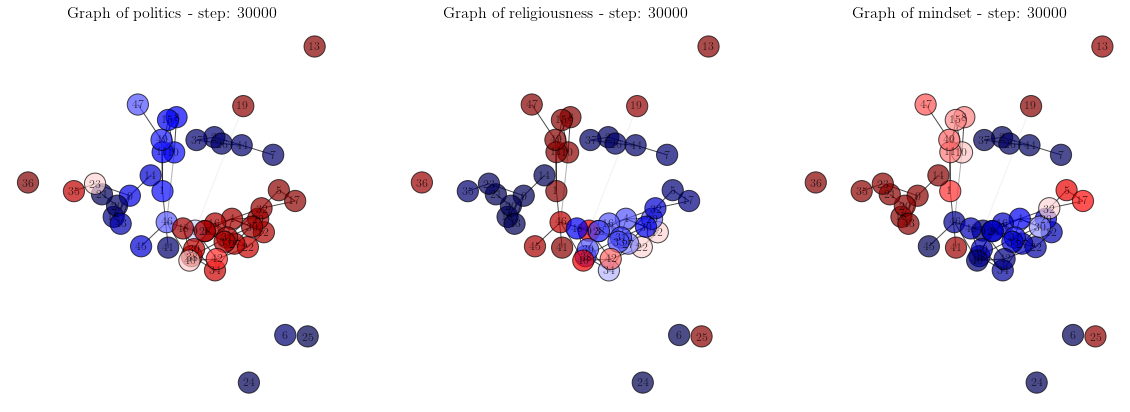

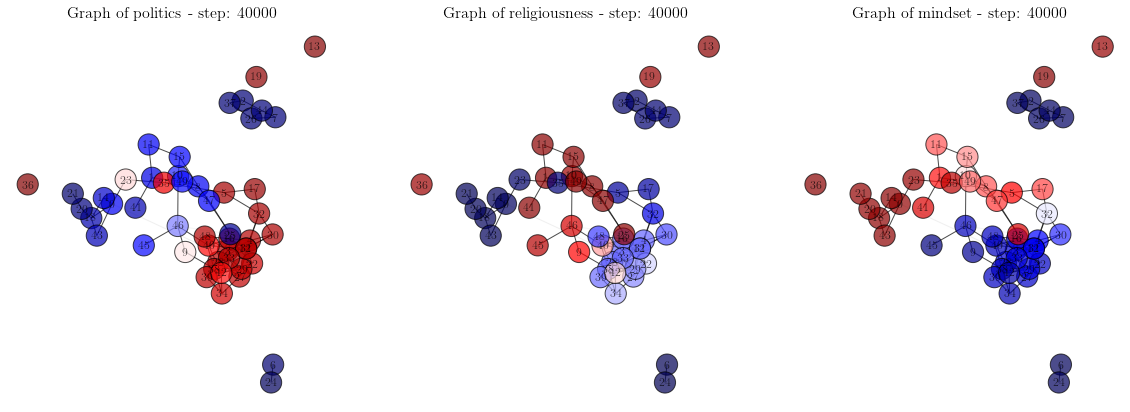

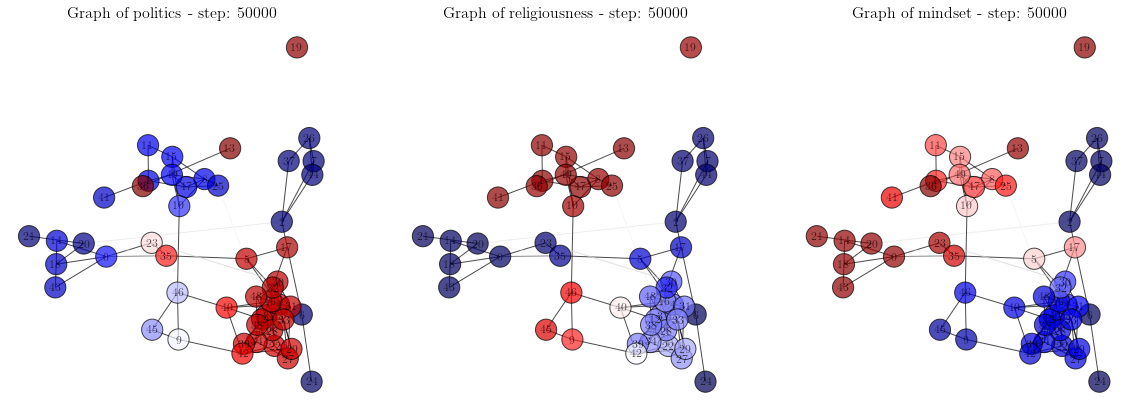

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 101
Average degree:   4.0400 
Average degree of neighbors in:  5.16


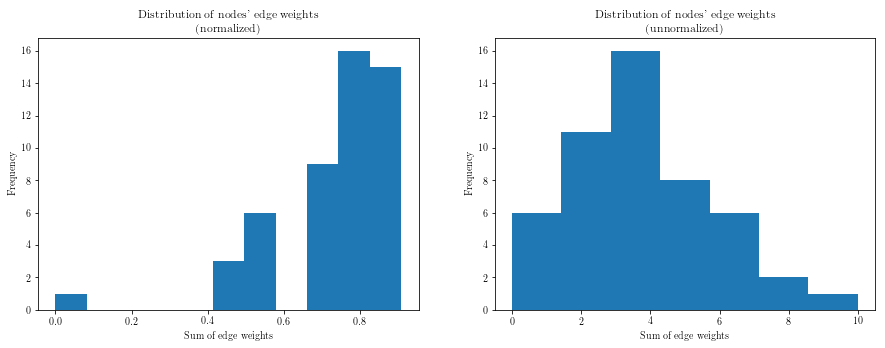

In [9]:
for i in range(5*10**4):
    sim_ts.update_trueskill()
    if sim_ts.step%(10**4)==0:
        sim_ts.observe_modified()        
print(nx.info(sim_ts.graph), '\nAverage degree of neighbors in: ', sim_ts.avg_deg_neighbor())
sim_ts.dunbar()

In [631]:
sim_ts.test_small_world()

Small-world: True  sigma = 1.7 > 1 
Small-world: True  -1 < omega = -0.01 < 1


In [10]:
# Display the persuasiveness skills
import pandas as pd
data = pd.DataFrame.from_dict(dict(sim_ts.graph.nodes(data=True)), orient='index')
data['mu persuasiveness'] = [data['rating'][_].mu for _ in range(len(data))]
data['sigma persuasiveness'] = [data['rating'][_].sigma for _ in range(len(data))]
data.drop(columns=['rating'], inplace=True)
data.sort_values(by=['mu persuasiveness'], ascending=False)

name  politics  religiousness   mindset  mu persuasiveness  \
12     Audrey  0.858301       0.385467  0.233251          82.983676   
8    Herminia  0.234733       0.952974  0.657119          76.438298   
1   Elizabeth  0.213031       0.969154  0.711309          75.950968   
6       Susan  0.051831       0.015827  0.023707          74.853328   
28     Thomas  0.869840       0.372821  0.214723          74.349301   
48      David  0.872772       0.344695  0.200723          74.118691   
34  Esperanza  0.839533       0.391222  0.212587          72.144755   
17    Darlene  0.915340       0.164355  0.613186          70.887019   
30   Jennifer  0.880350       0.338577  0.303637          68.303579   
18  Alexander  0.173888       0.028360  0.964517          68.033459   
2         Amy  0.065174       0.051851  0.033510          67.955032   
45     Jennie  0.388485       0.816422  0.115752          67.307902   
21      Bruce  0.066024       0.025490  0.966770          64.525108   
36      Tammy  0.990482       0.946272  0.980231          62.700799   
15   Virginia  0.248079       0.953687  0.624865          59.483021   
24      Lydia  0.035353       0.013907  0.023406          58.485701   
22     Martin  0.835861       0.419317  0.194705          58.131730   
7     Jeffery  0.071237       0.054032  0.033651          58.078896   
4     Candace  0.862706       0.349866  0.298186          57.652936   
41      Larry  0.179856       0.974491  0.784535          56.265636   
33     Milton  0.867886       0.378662  0.214699          55.863884   
23      Brian  0.533190       0.051247  0.917999          55.684701   
9       Linda  0.490016       0.713371  0.131614          55.519809   
38       Anne  0.862232       0.374196  0.192582          54.960530   
25  Christina  0.181016       0.963160  0.730244          52.511284   
13    Russell  0.984568       0.977126  0.955907          49.633125   
43    Eleanor  0.177638       0.033101  0.965912          47.941546   
37  Catherine  0.070158       0.053788  0.032036          47.436352   
5     William  0.872237       0.197516  0.544202          47.387179   
20      Berta  0.093425       0.024236  0.963109          46.338521   
14       Kyle  0.197775       0.031721  0.958210          46.024002   
49     Martha  0.240387       0.959320  0.644482          45.797016   
44      Carol  0.073147       0.053485  0.034030          44.925057   
19       Troy  0.963444       0.948254  0.973815          44.561733   
46    Antonio  0.437282       0.762545  0.211172          41.967860   
39      Marla  0.853938       0.374836  0.199662          40.410793   
27       Eric  0.853343       0.392788  0.204302          37.344355   
42     Warren  0.762643       0.495977  0.185204          35.920298   
35     Wilson  0.719136       0.095357  0.836795          34.619518   
11    Maureen  0.235376       0.967184  0.679281          32.614365   
16     Julian  0.857020       0.389293  0.218044          32.569580   
32       Mark  0.882700       0.286995  0.359193          32.187377   
47      Katie  0.218610       0.965518  0.696845          30.776289   
3       Jesse  0.863641       0.368968  0.219834          26.118307   
26      Amber  0.070270       0.054413  0.032878          25.802267   
10    Theresa  0.297165       0.928178  0.552971          24.613627   
0       Jerry  0.267719       0.033697  0.957541          24.327401   
29       Toni  0.842089       0.415605  0.219850          18.638712   
40       Mary  0.745243       0.517471  0.211622          15.972808   
31     Sondra  0.867697       0.362975  0.260923           8.831440   

    sigma persuasiveness  
12              2.114848  
8               2.149655  
1               2.190888  
6               1.110490  
28              2.187174  
48              1.950596  
34              2.218895  
17              1.911576  
30              1.455600  
18              2.269336  
2               1.192765  
45              1.353374  
21              1.757943  
36       

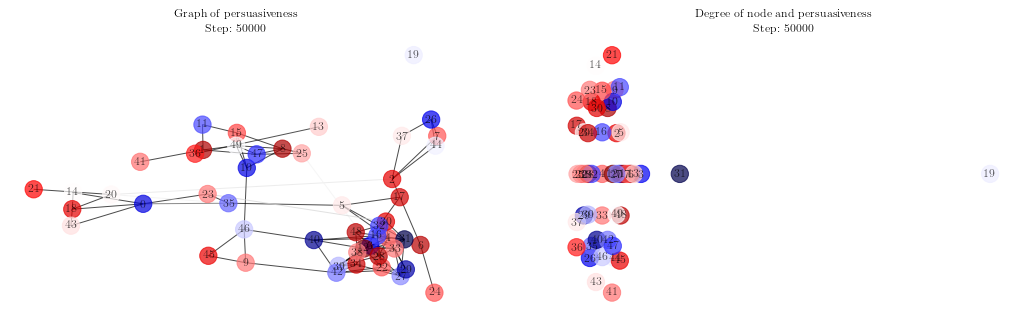

In [11]:
# Draw the network using the color coding of persuasiveness
def compute_network_layout(graph):
    '''
    Compute the shell layout of the simulation network.
    Code from session 9.1 on SIS Epidemic model.
    '''
    nodes_for_degree = {}
    for node in graph.nodes:
        degree = graph.degree[node]
        nodes_for_degree.setdefault(degree, []).append(node)
    shells = [x[1] for x in sorted(nodes_for_degree.items(), reverse=True)]
    return nx.shell_layout(graph, shells)

plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
nx.draw(sim_ts.graph, pos=sim_ts.layout, with_labels=True,
        node_color=[sim_ts.graph.nodes[i]['rating'].mu for i in sim_ts.graph.nodes],
        edge_color=[sim_ts.graph.edges[i, j]['weight'] for i, j in sim_ts.graph.edges],
        edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1, cmap=plt.cm.seismic,
        alpha=0.7, vmin=min(data['mu persuasiveness']), vmax=max(data['mu persuasiveness']))
plt.title('Graph of persuasiveness\nStep: ' + str(sim_ts.step))

plt.subplot(1,2,2)
nx.draw(sim_ts.graph, pos=compute_network_layout(sim_ts.graph), with_labels=True,
        node_color=[sim_ts.graph.nodes[i]['rating'].mu for i in sim_ts.graph.nodes],
        edgelist=[], cmap=plt.cm.seismic,
        alpha=0.7, vmin=min(data['mu persuasiveness']), vmax=max(data['mu persuasiveness']))
plt.title('Degree of node and persuasiveness\nStep: ' + str(sim_ts.step))
plt.show()

In [26]:
data = []
for node in sim_ts.graph.nodes:
    data.append([node, sim_ts.graph.nodes[node]['name'], 
                sim_ts.graph.nodes[node]['rating'].mu, 
                len(list(sim_ts.graph.edges(node))),
                sum([sim_ts.graph.edges[edge]['weight'] 
                     for edge in sim_ts.graph.edges(node)])])

data = pd.DataFrame(data, columns=['Node','Name','Skill','Degree','Relations'])
data.sort_values(by=['Skill'], ascending=False)

Node       Name      Skill  Degree  Relations
12    12     Audrey  82.983676       7   6.999815
8      8   Herminia  76.438298       5   5.000000
1      1  Elizabeth  75.950968       4   4.000000
6      6      Susan  74.853328       2   1.993566
28    28     Thomas  74.349301       6   6.000000
48    48      David  74.118691       4   3.982464
34    34  Esperanza  72.144755       5   4.999968
17    17    Darlene  70.887019       2   2.000000
30    30   Jennifer  68.303579       5   4.166118
18    18  Alexander  68.033459       4   4.000000
2      2        Amy  67.955032       5   4.096169
45    45     Jennie  67.307902       2   2.000000
21    21      Bruce  64.525108       1   1.000000
36    36      Tammy  62.700799       1   0.961044
15    15   Virginia  59.483021       4   4.000000
24    24      Lydia  58.485701       1   1.000000
22    22     Martin  58.131730       4   4.000000
7      7    Jeffery  58.078896       3   3.000000
4      4    Candace  57.652936      10   9.999464
41    41      Larry  56.265636       1   1.000000
33    33     Milton  55.863884       7   7.000000
23    23      Brian  55.684701       3   2.166118
9      9      Linda  55.519809       3   3.000000
38    38       Anne  54.960530       5   5.000000
25    25  Christina  52.511284       3   2.051748
13    13    Russell  49.633125       1   0.961044
43    43    Eleanor  47.941546       2   2.000000
37    37  Catherine  47.436352       2   2.000000
5      5    William  47.387179       4   3.999993
20    20      Berta  46.338521       4   2.162647
14    14       Kyle  46.024002       2   2.000000
49    49     Martha  45.797016       5   5.000000
44    44      Carol  44.925057       3   3.000000
19    19       Troy  44.561733       0   0.000000
46    46    Antonio  41.967860       4   4.000000
39    39      Marla  40.410793       5   4.999815
27    27       Eric  37.344355       6   6.000000
42    42     Warren  35.920298       5   5.000000
35    35     Wilson  34.619518       4   2.706668
11    11    Maureen  32.614365       2   2.000000
16    16     Julian  32.569580       7   7.000000
32    32       Mark  32.187377       7   6.982432
47    47      Katie  30.776289       4   4.000000
3      3      Jesse  26.118307       9   8.051748
26    26      Amber  25.802267       3   3.000000
10    10    Theresa  24.613627       4   4.000000
0      0      Jerry  24.327401       5   4.646623
29    29       Toni  18.638712       4   4.000000
40    40       Mary  15.972808       5   4.999472
31    31     Sondra   8.831440       8   8.000000

## Watts and Strogatz model

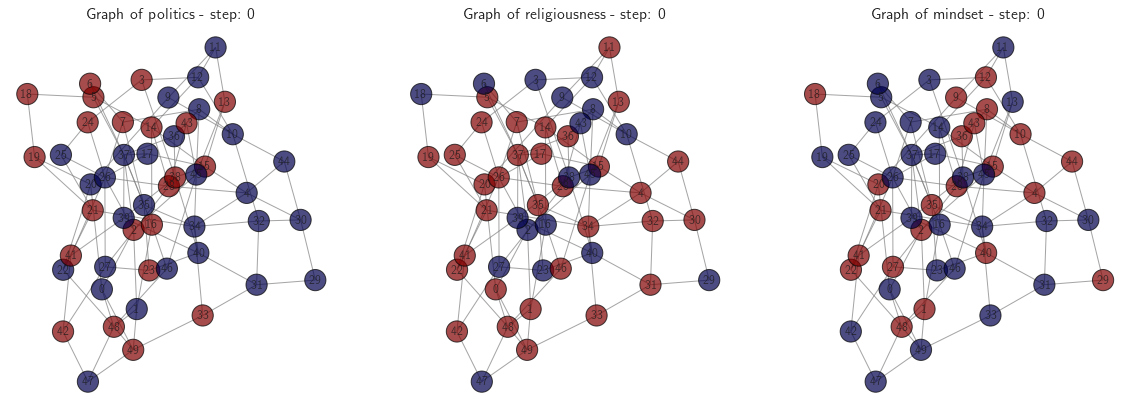

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 100
Average degree:   4.0000 
Average degree of neighbors in:  4.45


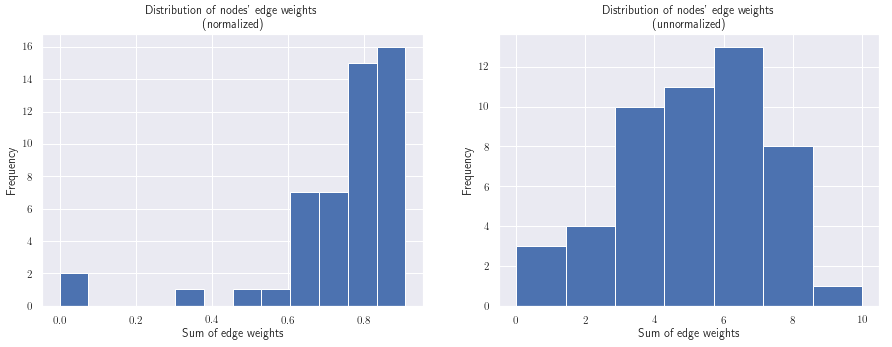

In [584]:
sim_ws = SocialDynamicsSimulation()
sim_ws.initialize(nx.watts_strogatz_graph(50, 5, 0.5))
sim_ws.observe_modified()
print(nx.info(sim_ws.graph), '\nAverage degree of neighbors in: ', sim_ws.avg_deg_neighbor())
sim_ws.dunbar()

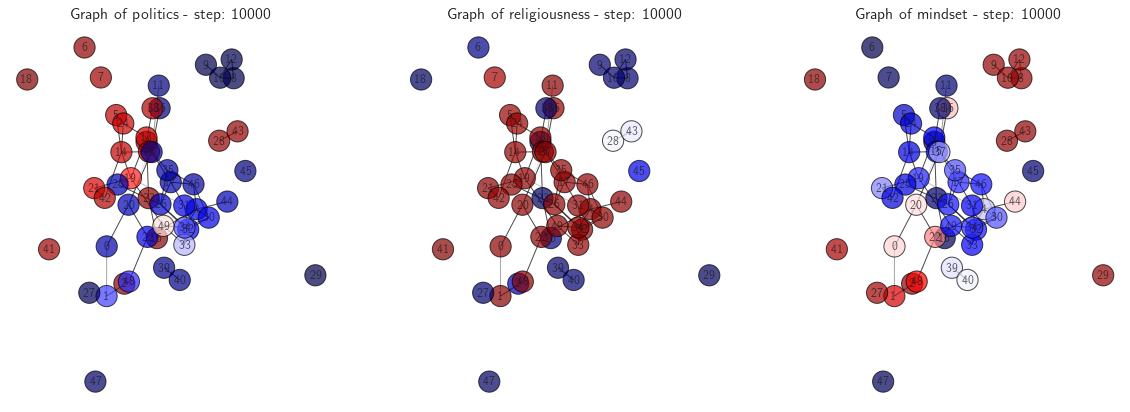

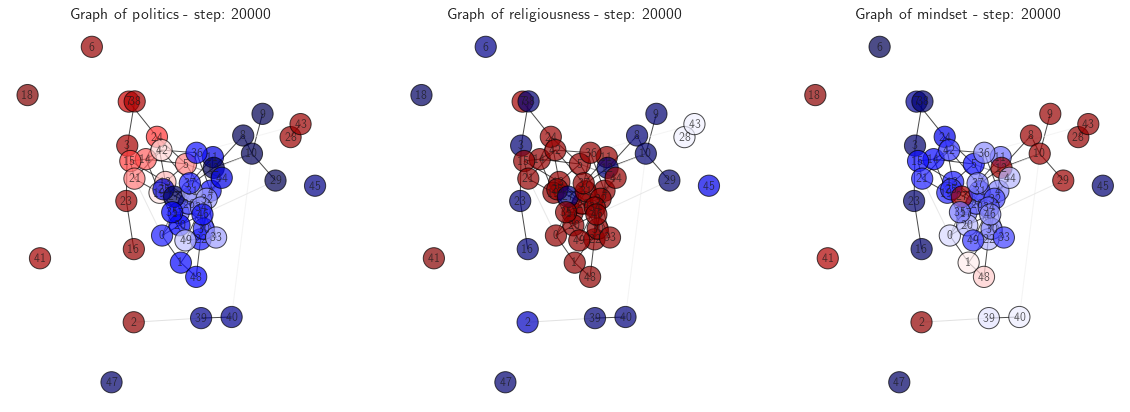

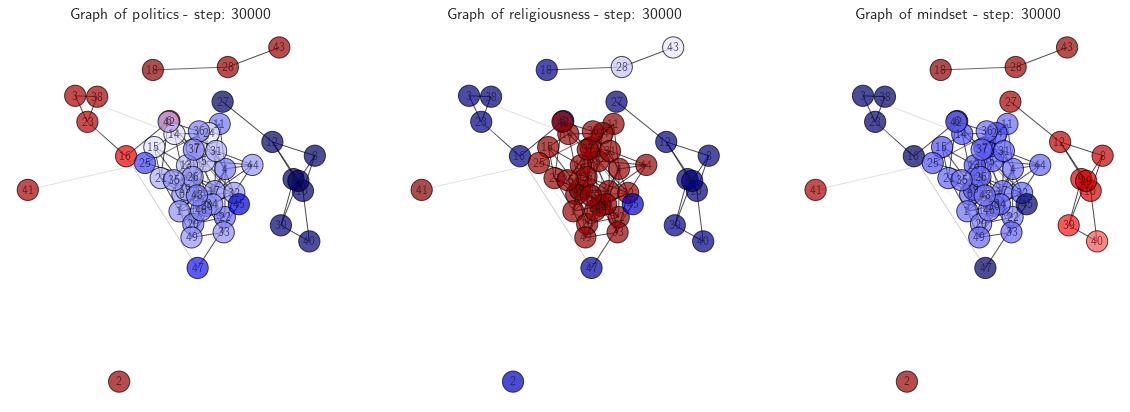

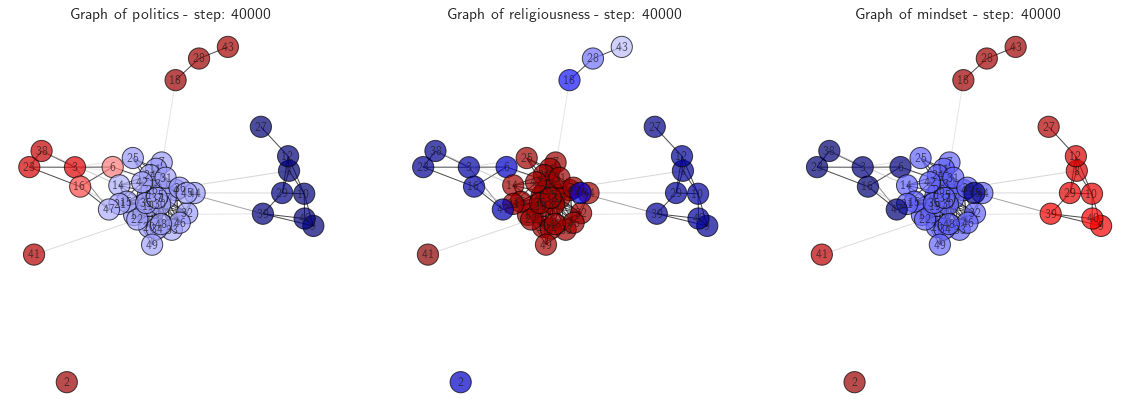

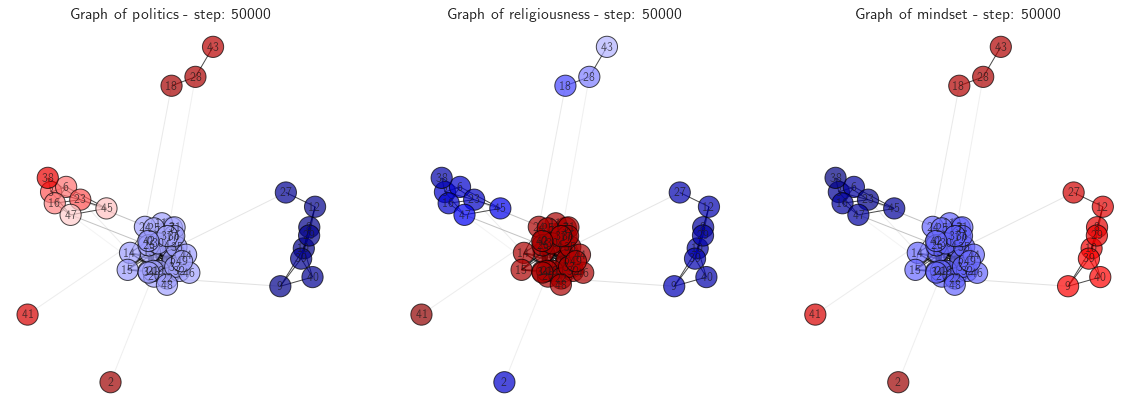

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 207
Average degree:   8.2800 
Average degree of neighbors in:  10.97


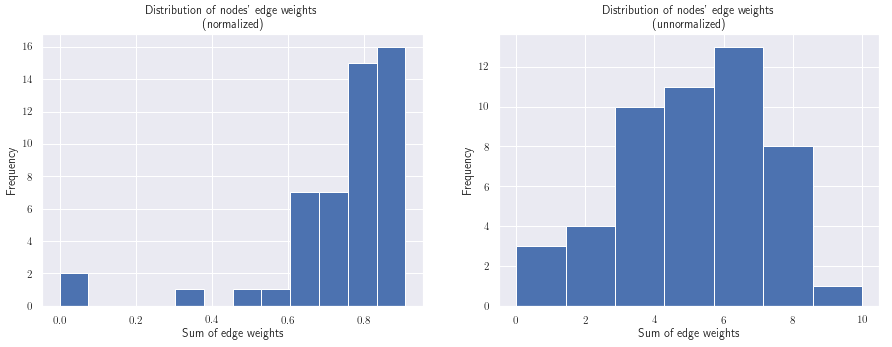

In [585]:
for i in range(5*10**4):
    sim_ws.update_modified()
    if sim_ws.step%(10**4)==0:
        sim_ws.observe_modified()        
print(nx.info(sim_ws.graph), '\nAverage degree of neighbors in: ', sim_ws.avg_deg_neighbor())
sim_ws.dunbar()

In [642]:
sim_ws.test_small_world()

Small-world: True  sigma = 1.22 > 1 
Small-world: True  -1 < omega = -0.05 < 1


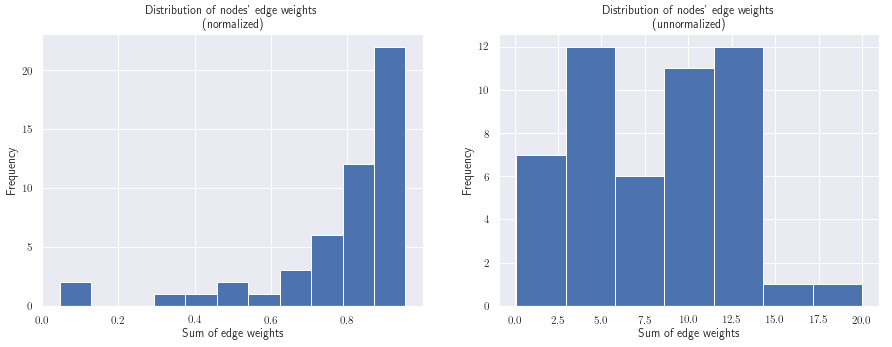

In [648]:
sim_ws.dunbar()

## Barabási-Albert model

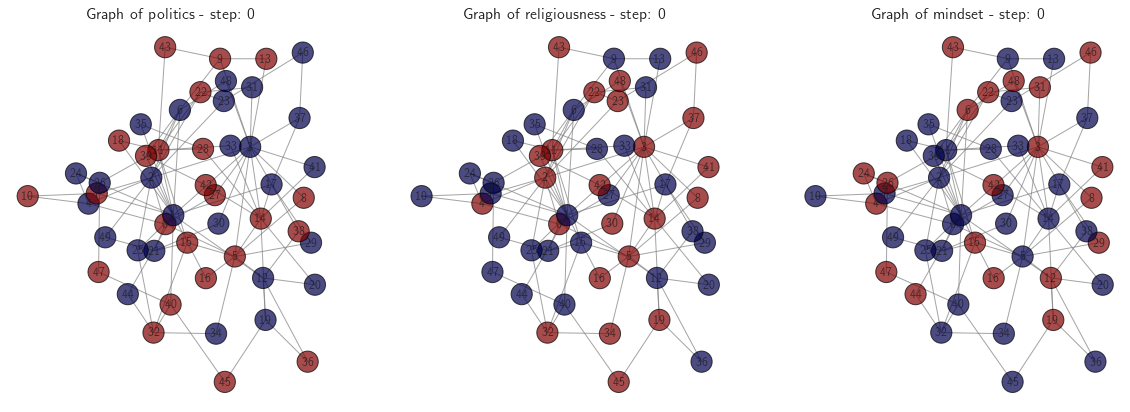

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 96
Average degree:   3.8400 
Average degree of neighbors in:  6.16


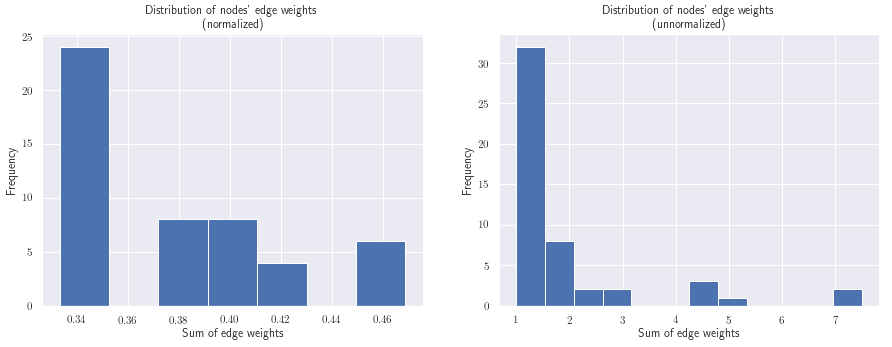

In [638]:
sim_ba = SocialDynamicsSimulation()
sim_ba.initialize(nx.barabasi_albert_graph(50, 2))
sim_ba.observe_modified()

print(nx.info(sim_ba.graph), '\nAverage degree of neighbors in: ', sim_ba.avg_deg_neighbor())
sim_ba.dunbar()

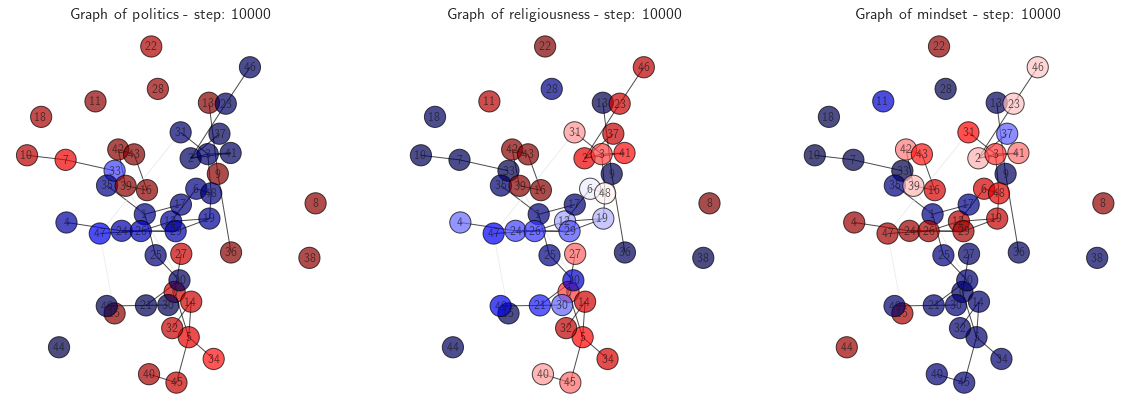

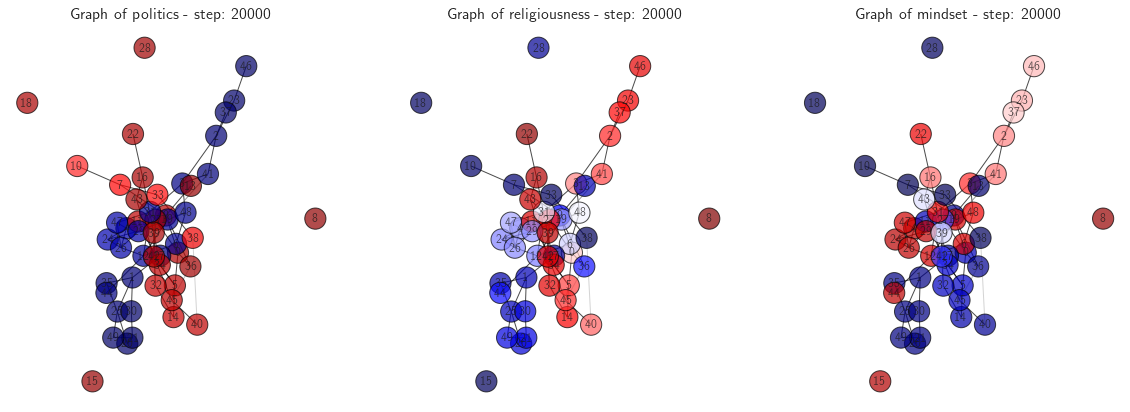

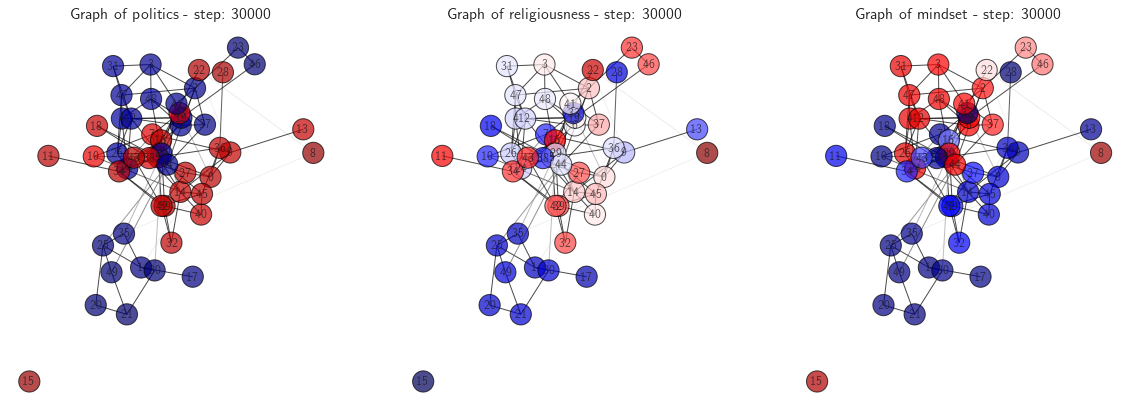

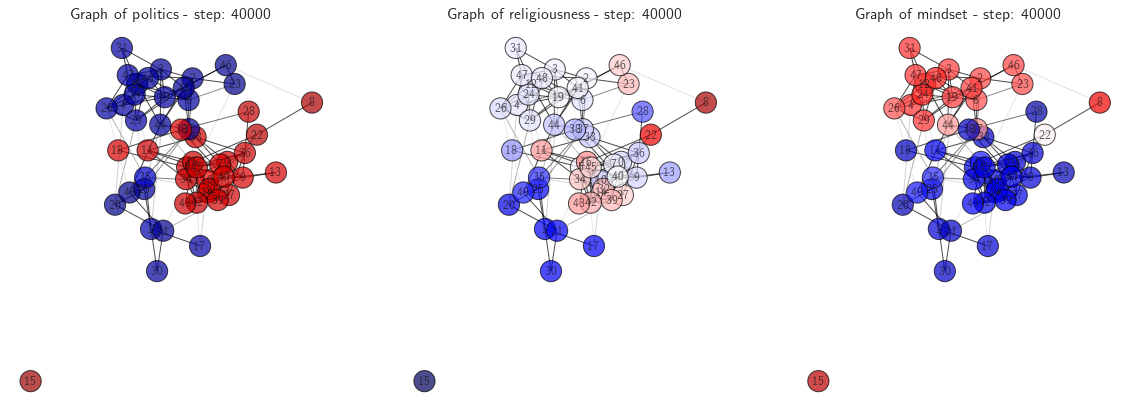

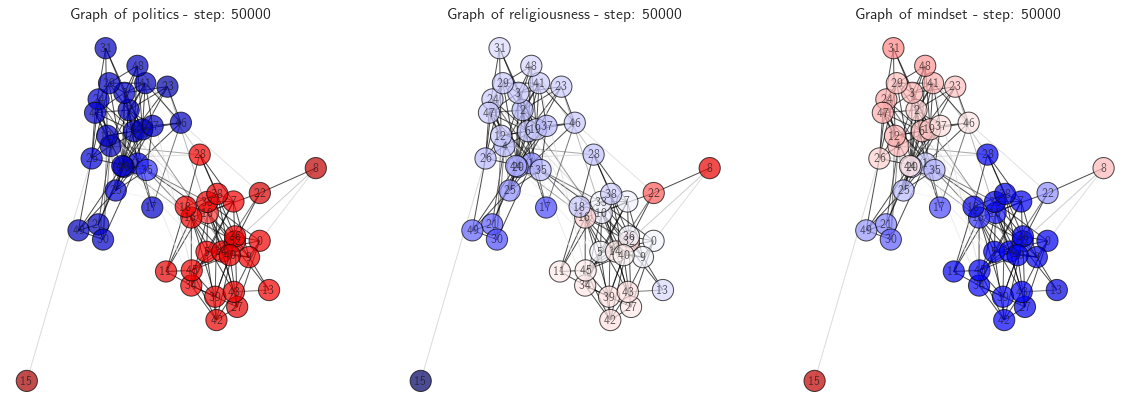

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 187
Average degree:   7.4800 
Average degree of neighbors in:  8.26


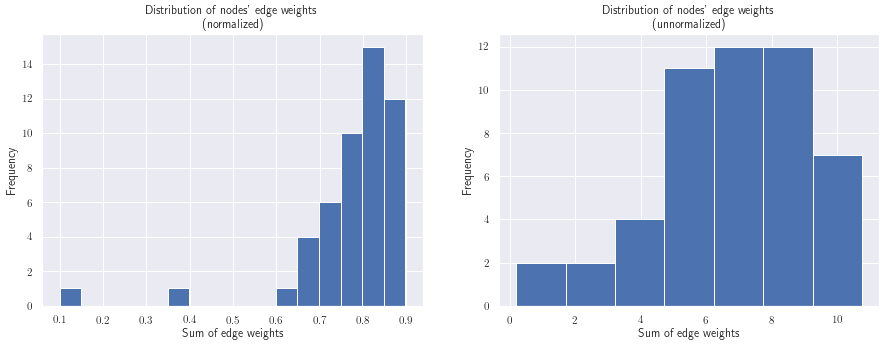

In [639]:
for i in range(5*10**4):
    sim_ba.update_modified()
    if sim_ba.step%(10**4)==0:
        sim_ba.observe_modified()
        
print(nx.info(sim_ba.graph), '\nAverage degree of neighbors in: ', sim_ba.avg_deg_neighbor())
sim_ba.dunbar()

In [643]:
sim_ba.test_small_world()

Small-world: True  sigma = 1.63 > 1 
Small-world: True  -1 < omega = 0.47 < 1


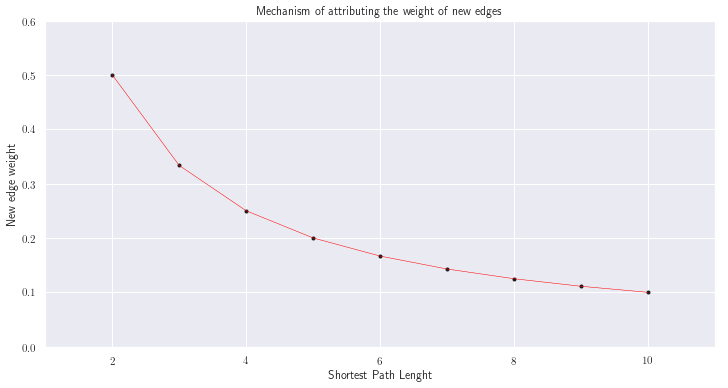

In [348]:
# The funciton for creating a new edge
x = np.array(range(2, 11))
f = lambda x: 1/(x)
plt.figure(figsize=(12, 6))
plt.plot(x, f(x), 'k.'); plt.plot(x, f(x), 'k-', color='red', linewidth=.5)
plt.xlim(1, 11); plt.ylim(0, .6)
plt.title('Mechanism of attributing the weight of new edges')
plt.xlabel('Shortest Path Lenght'); plt.ylabel('New edge weight')
plt.show()

# Exploring real-world data
The idea was to use the Facebook network as a template graph for the social network model. The graph contains all friends of 10 nodes (the info of the graph are printed below)

<code>Data source:</code> https://snap.stanford.edu/data/ego-Facebook.html

<code>Colab Notebook:</code> https://colab.research.google.com/drive/16vAiMdbj1AJZDQi1QtOik-MxWWoDJKaD#scrollTo=0CtMt3FgW8HM

In [649]:
import seaborn as sns
sns.set()
facebook = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
print(nx.info(facebook))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


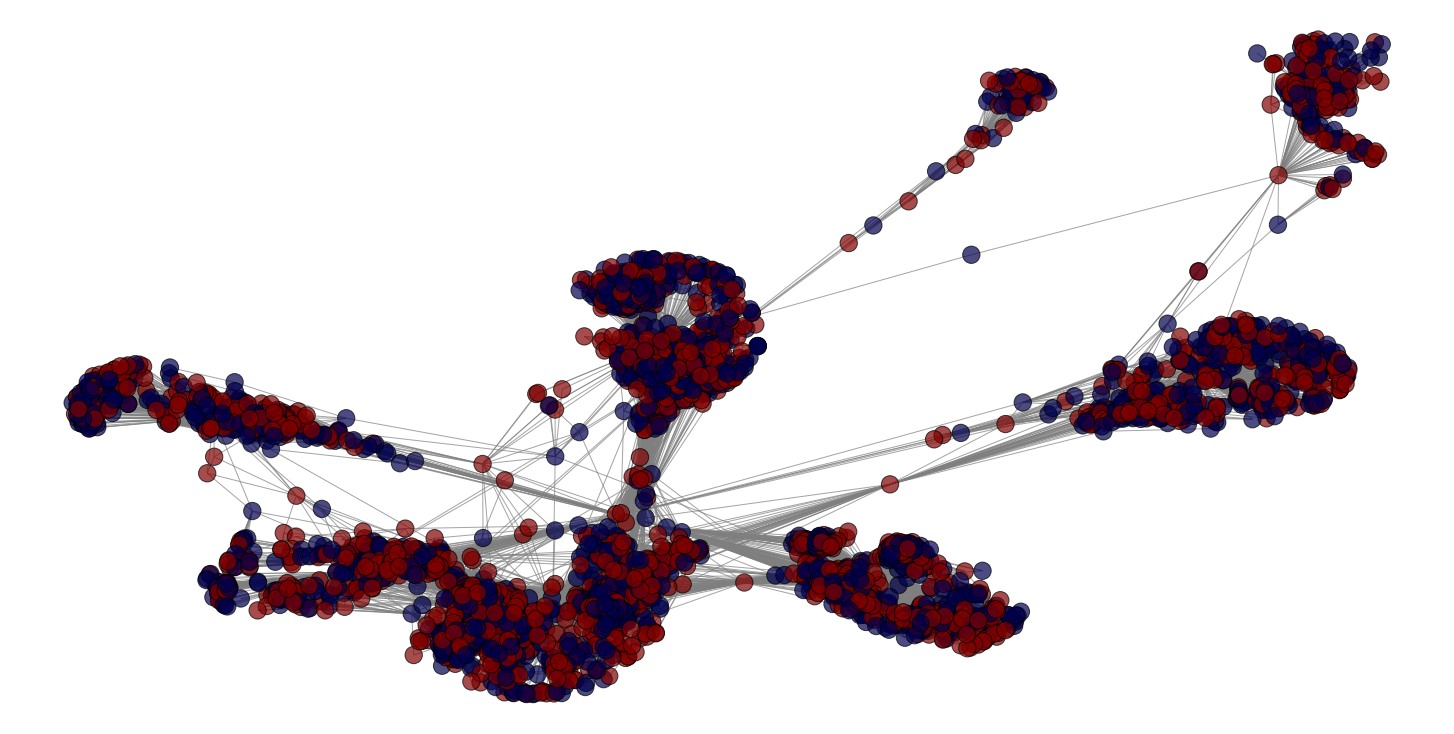

In [653]:
from PIL import Image
Image.open('facebook_init.png')

In [651]:
short_path_dist = []
for source, source_lengths in nx.all_pairs_shortest_path_length(facebook):
    short_path_dist.extend(x[1] for x in source_lengths.items() if x[0] > source)
    
degree_dist = [degree for node, degree in facebook.degree]

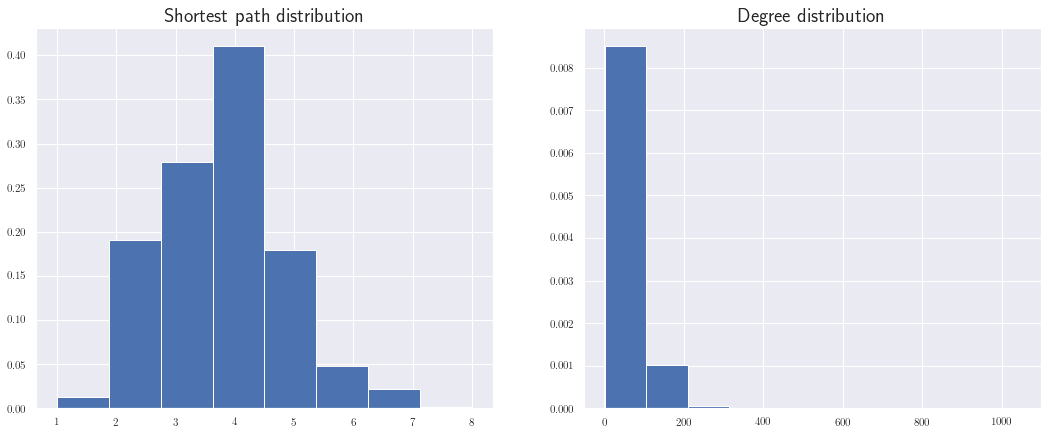

In [652]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.hist(short_path_dist, bins=8, density=True)
plt.title('Shortest path distribution', fontsize=20)

plt.subplot(1, 2, 2)
plt.hist(degree_dist, density=True)
plt.title('Degree distribution', fontsize=20)
plt.show()

In [ ]:
#nx.average_clustering(facebook)

In [ ]:
#nx.average_shortest_path_length(facebook)

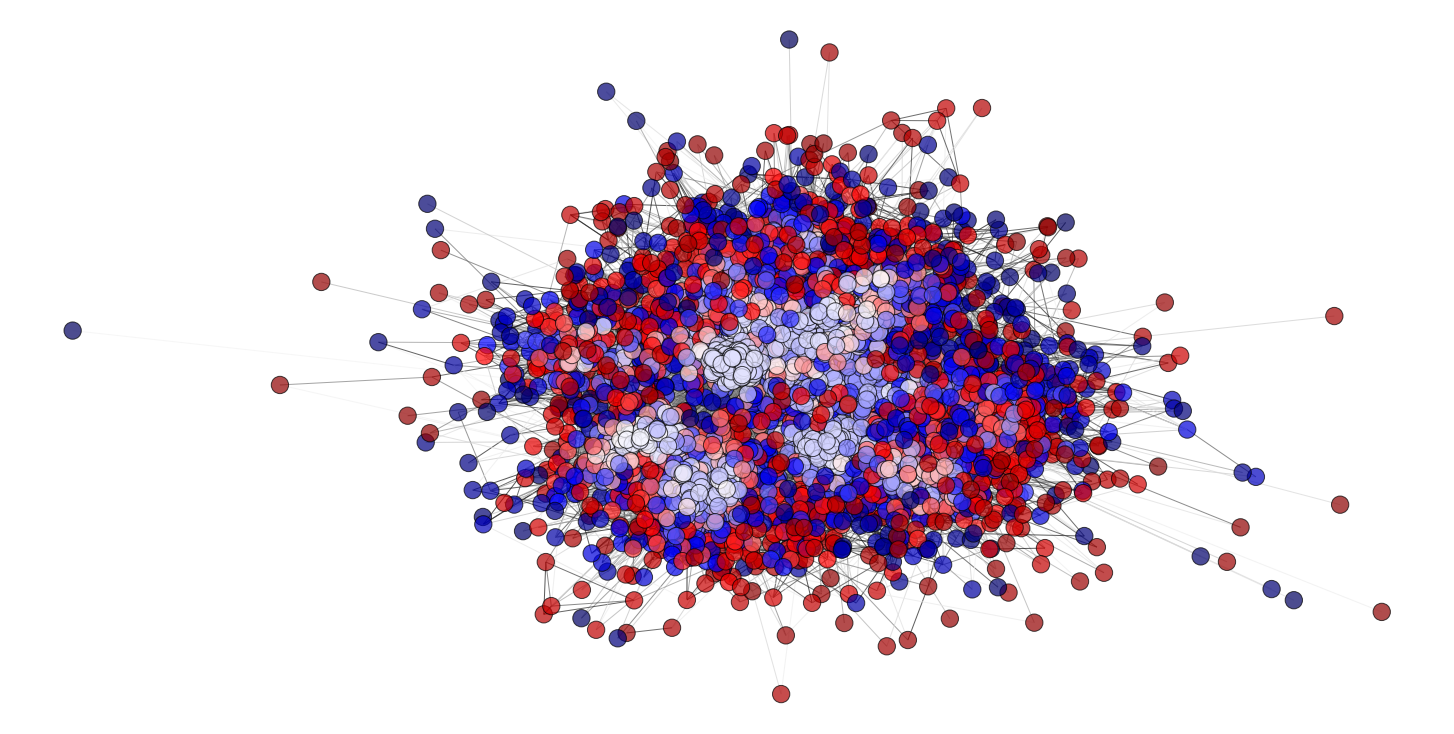

In [654]:
Image.open('facebook_final.png')